In [10]:
import matplotlib.pyplot as plt
import numpy as np
import openslide
import os
import random
import scanpy as sc
import tifffile
import time
import timm
import torch
from PIL import Image, ImageDraw
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

In [11]:
# Paths and parameters
data = "Xenium_5K_OC"
data_dir = f"../../data/{data}/"
utils_dir = "../../data/_utils/"

In [12]:
# Read adata
adata = sc.read_h5ad(data_dir + "intermediate_data/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 327607 × 5001
    obs: 'cell_id', 'global_x', 'global_y', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'x_pixel', 'y_pixel', 'cell_type', 'cell_type_merged'
    var: 'gene_ids', 'feature_types', 'genome', 'gene'
    uns: 'cell_type_colors', 'cell_type_merged_colors'

In [13]:
# Read image
img = tifffile.imread(data_dir + "raw_data/HE_image.tif")
img.shape

(43993, 30918, 3)

In [14]:
# Load UNI architecture and weights
timm_kwargs = {
    'model_name': 'vit_giant_patch14_224',
    'img_size': 224, 
    'patch_size': 14, 
    'depth': 24,
    'num_heads': 24,
    'init_values': 1e-5, 
    'embed_dim': 1536,
    'mlp_ratio': 2.66667*2,
    'num_classes': 0, 
    'no_embed_class': True,
    'mlp_layer': timm.layers.SwiGLUPacked, 
    'act_layer': torch.nn.SiLU, 
    'reg_tokens': 8, 
    'dynamic_img_size': True
}
model = timm.create_model(**timm_kwargs)
model.load_state_dict(torch.load(utils_dir + "UNI/ckpts/uni2-h/pytorch_model.bin", map_location="cpu"))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
    

In [58]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [59]:
# Load image WSI
slide = openslide.OpenSlide(data_dir + "raw_data/HE_image.tif")
width, height = slide.dimensions

In [60]:
# Get thumbnail for visualization
thumbnail = slide.get_thumbnail((2500, int(2500 * slide.dimensions[1] / slide.dimensions[0])))
thumb_width, thumb_height = thumbnail.size
scale_x = thumb_width / width
scale_y = thumb_height / height

In [61]:
# Cell-centered patch extraction
patch_size = 100
coords, patches = [], []

adata_downsampled = adata[adata.obs.sample(frac=0.005, random_state=1).index]

for i in range(adata_downsampled.shape[0]):
    
    # cell center coordinates
    x_pixel = int(adata_downsampled.obs["x_pixel"].values[i])
    y_pixel = int(adata_downsampled.obs["y_pixel"].values[i])
    
    # patch top left coordinates
    x_top_left = max(0, min(width - patch_size, x_pixel - patch_size // 2))
    y_top_left = max(0, min(height - patch_size, y_pixel - patch_size // 2))
    coords.append((x_top_left, y_top_left))
    
    # extract patch
    patch = slide.read_region((x_top_left, y_top_left), level=0, size=(patch_size, patch_size)).convert("RGB")
    patches.append(patch)

In [62]:
# Draw patch locations on thumbnail
draw = ImageDraw.Draw(thumbnail)

for i in range(adata_downsampled.shape[0]):
    
    # cell center
    x_pixel = int(adata_downsampled.obs["x_pixel"].values[i])
    y_pixel = int(adata_downsampled.obs["y_pixel"].values[i])
    
    # patch top left
    x, y = coords[i]
    x1 = x * scale_x
    y1 = y * scale_y
    x2 = (x + patch_size) * scale_x
    y2 = (y + patch_size) * scale_y
    
    # draw center and rectangle
    draw.ellipse([x_pixel * scale_x - 0.5, y_pixel * scale_y - 0.5, x_pixel * scale_x + 0.5, y_pixel * scale_y + 0.5], fill="blue")
    draw.rectangle([x1, y1, x2, y2], outline="red", width=1)

In [63]:
thumbnail.save("WSI_patches_annotated.png")

In [64]:
# UNI transform
uni_input = torch.stack([transform(p) for p in patches])
uni_input.shape

torch.Size([1638, 3, 224, 224])

In [65]:
# Extract embeddings in batches
batch_size = 200
all_outputs = []

start = time.time()

for i in range(0, uni_input.shape[0], batch_size):
    print(i)
    batch = uni_input[i:i+batch_size]
    with torch.inference_mode():
        output = model(batch)
    all_outputs.append(output.cpu())

feature_emb = torch.cat(all_outputs, dim=0)
print("Elapsed time:", (time.time() - start)/60, "min")

0
200
400
600
800
1000
1200
1400
1600
Elapsed time: 29.337194967269898 min


In [66]:
feature_emb.shape

torch.Size([1638, 1536])

In [83]:
adata_img = sc.AnnData(feature_emb.numpy())
adata_img.obs["x"] = [c[0] for c in coords]
adata_img.obs["y"] = [c[1] for c in coords]

In [84]:
sc.pp.scale(adata_img)

In [85]:
sc.tl.pca(adata_img)

In [86]:
sc.pp.neighbors(adata_img, n_neighbors=15)

In [87]:
sc.tl.umap(adata_img)

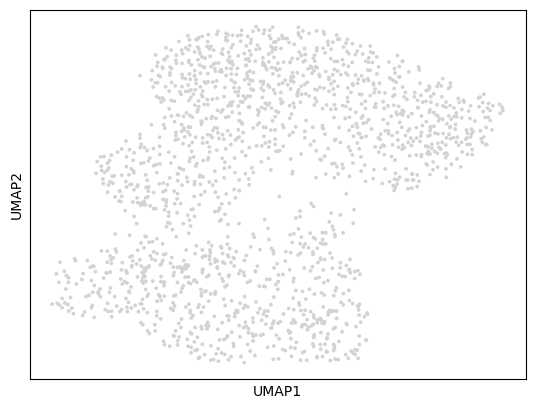

In [88]:
sc.pl.umap(adata_img, size=30)

In [95]:
sc.tl.louvain(adata_img, resolution=0.5)

In [96]:
sc.set_figure_params(figsize = (6, 6))
ax = sc.pl.umap(adata_img, color="louvain", size=30, show=False)
ax.grid(False)
plt.savefig("UNI_clustering.jpeg", dpi = 300, bbox_inches = "tight")
plt.close()

In [97]:
import matplotlib.patches as pch

for cluster in adata_img.obs["louvain"].unique():
    idx = adata_img.obs["louvain"] == cluster
    subset = [patches[i] for i in range(len(patches)) if idx[i]][:16]
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for ax, p in zip(axes.flat, subset):
        ax.imshow(p)
        ax.axis("off")
        # Add black border
        rect = pch.Rectangle(
            (0, 0), 1, 1,
            linewidth=3,
            edgecolor='black',
            facecolor='none',
            transform=ax.transAxes
        )
        ax.add_patch(rect)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig(f"cluster_{cluster}_examples.jpeg", dpi=300, bbox_inches="tight")
    plt.close()